In [178]:
cd /content/drive/MyDrive/CIS 581/final_project

/content/drive/MyDrive/CIS 581/final_project


In [179]:
import cv2
import numpy as np
from detection import detect_faces
from feature_extraction import extract_feature
from morphing import ImageMorphingTriangulation, face_swap
from blending import blending
from optical_flow import optical_flow
from google.colab.patches import cv2_imshow
import scipy
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import scipy.signal as signal


In [180]:
video_source = './2.mp4'
video_target = './1.mp4'

frame_rate = 5
needDetection = True

In [181]:
cap_source = cv2.VideoCapture(video_source)
cap_target = cv2.VideoCapture(video_target)

In [182]:
source_num_frame = int(cap_source.get(cv2.CAP_PROP_FRAME_COUNT))
target_num_frame = int(cap_target.get(cv2.CAP_PROP_FRAME_COUNT))
num_frame = min(source_num_frame, target_num_frame)

count_frame = 0

In [183]:
def getIndexes(mask, targetH, targetW, offsetX=0, offsetY=0):
    """ Creates indexes in the target image, each replacement pixel in the
    target image would get index starting from 1, other pixels get 0 in the indexes.

    Args:
    mask: SrcH * SrcW, logical mask of source image
    targetH, targetW: int, height and width of target image
    offsetX, offsetY: int, offset of replacement pixel area from source to target

    Return:
    indexes: targetH * targetW, indexes of target image
    """
    # IMPLEMENT HERE
    # you might find numpy.meshgrid and numpy.arange useful
    x, y = np.meshgrid(np.arange(mask.shape[1]), np.arange(mask.shape[0]))
    target_x, target_y = x[mask > 0], y[mask > 0]

    indexes = np.zeros((targetH, targetW))
    indexes[target_y+offsetY, target_x+offsetX] = np.arange(1, target_x.shape[0]+1)

    return indexes

In [184]:
def getCoefficientMatrix(indexes):
  """
  constructs the coefficient matrix(A in Ax=b)
  
  Args: 
  indexes: targetH * targetW, indexes of target image starting from 1, 0 if not in target area 
  
  returns:
  coeffA: N * N(N is max index), a matrix corresponds to laplacian kernel, 4 on the diagonal and -1 for each neighbor
  """
  # IMPLEMENT HERE
  # the coefficient matrix is by nature sparse. consider using scipy.sparse.csr_matrixr

  Y, X = np.nonzero(indexes)
  N = np.count_nonzero(indexes)

  left = np.zeros(N, dtype=np.int32)
  right = np.zeros(N, dtype=np.int32)
  up = np.zeros(N, dtype=np.int32)
  down = np.zeros(N, dtype=np.int32)

  valid = X - 1 >= 0
  left[valid] = indexes[Y[valid], (X - 1)[valid]]
  valid = X + 1 >= 0
  right[valid] = indexes[Y[valid], (X + 1)[valid]]
  valid = Y - 1 >= 0
  down[valid] = indexes[(Y - 1)[valid], X[valid]]
  valid = Y + 1 >= 0
  up[valid] = indexes[(Y + 1)[valid], X[valid]]

  
  neighbor = np.append(np.append(left, right), np.append(up, down))

  x = np.tile(np.arange(0, N), 4)
  j = (neighbor - 1)[neighbor > 0]
  i = x[neighbor > 0]
  k = -1 * np.ones(i.shape[0])

  row = np.arange(0, N)
  col = np.arange(0, N)
  data = 4 * np.ones_like(row)

  row = np.append(row, i)
  col = np.append(col, j)
  data = np.append(data, k)

  A_sparse = scipy.sparse.csr_matrix((data,(row,col)), shape=(N, N))

  return A_sparse

In [185]:
def getSolutionVect(indexes, source, target_img, offsetX, offsetY):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # 1. get Laplacian part of b from source image
    laplacian = np.array([[0, -1, 0], 
                [-1, 4, -1], 
                [0, -1, 0]])
    src_laplacian = scipy.signal.convolve(source, laplacian, 'same')

    Y, X = np.nonzero(indexes)
    Y_src, X_src = Y - offsetY, X - offsetX
    laplacian = src_laplacian[Y_src, X_src]
    
    # 2. get pixel part of b from target image
    Y, X = np.nonzero(indexes)
    N = np.count_nonzero(indexes)

    left_idx = np.zeros(N, dtype=np.int32)
    left_val = np.zeros(N, dtype=np.float32)
    valid = X - 1 >= 0
    left_idx[valid] = indexes[Y[valid], (X - 1)[valid]]
    good = np.logical_and(valid, left_idx == 0)
    left_val[good] = target_img[Y[good], (X - 1)[good]]

    right_idx = np.zeros(N, dtype=np.int32)
    right_val = np.zeros(N, dtype=np.float32)
    valid = X + 1 >= 0
    right_idx[valid] = indexes[Y[valid], (X + 1)[valid]]
    good = np.logical_and(valid, right_idx == 0)
    right_val[good] = target_img[Y[good], (X + 1)[good]]

    up_idx = np.zeros(N, dtype=np.int32)
    up_val = np.zeros(N, dtype=np.float32)
    valid = Y - 1 >= 0
    up_idx[valid] = indexes[(Y - 1)[valid], X[valid]]
    good = np.logical_and(valid, up_idx == 0)
    up_val[good] = target_img[(Y - 1)[good], X[good]]

    down_idx = np.zeros(N, dtype=np.int32)
    down_val = np.zeros(N, dtype=np.float32)
    valid = Y + 1 >= 0
    down_idx[valid] = indexes[(Y + 1)[valid], X[valid]]
    good = np.logical_and(valid, down_idx == 0)
    down_val[good] = target_img[(Y + 1)[good], X[good]]

    # 3. add two parts together to get b
    b = laplacian + left_val + right_val + up_val + down_val

    return b

In [186]:
def getSolutionVectTexture(indexes, target_img, mask, edges):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b

    # 1. get Laplacian part of b from source image
    laplacian = np.array([[0, -1, 0], 
                [-1, 4, -1], 
                [0, -1, 0]])
    trg_laplacian = scipy.signal.convolve(target_img, laplacian, 'same')

    Y, X = np.nonzero(indexes)

    laplacian = np.array([[0, 1, -1]])
    trg1 = scipy.signal.convolve(target_img, laplacian, 'same')
    trg1[Y,X] = np.where(np.logical_or(edges[Y, X] == 1, edges[Y, X-1] == 1), trg1[Y, X], 0)

    laplacian = np.array([[0], [1], [-1]])
    trg2 = scipy.signal.convolve(target_img, laplacian, 'same')
    trg2[Y,X] = np.where(np.logical_or(edges[Y, X] == 1, edges[Y-1, X] == 1), trg2[Y, X], 0)

    laplacian = np.array([[-1, 1, 0]])
    trg3 = scipy.signal.convolve(target_img, laplacian, 'same')
    trg3[Y,X] = np.where(np.logical_or(edges[Y, X] == 1, edges[Y, X+1] == 1), trg3[Y, X], 0)

    laplacian = np.array([[-1], [1], [0]])
    trg4 = scipy.signal.convolve(target_img, laplacian, 'same')
    trg4[Y,X] = np.where(np.logical_or(edges[Y, X] == 1, edges[Y+1, X] == 1), trg4[Y, X], 0)

    trg_laplacian = trg1 + trg2 + trg3 + trg4


    Y_src, X_src = Y, X

    laplacian = trg_laplacian[Y, X]
    
    # 2. get pixel part of b from target image
    Y, X = np.nonzero(indexes)
    N = np.count_nonzero(indexes)

    left_idx = np.zeros(N, dtype=np.int32)
    left_val = np.zeros(N, dtype=np.float32)
    valid = X - 1 >= 0
    left_idx[valid] = indexes[Y[valid], (X - 1)[valid]]
    good = np.logical_and(valid, left_idx == 0)
    left_val[good] = target_img[Y[good], (X - 1)[good]]

    right_idx = np.zeros(N, dtype=np.int32)
    right_val = np.zeros(N, dtype=np.float32)
    valid = X + 1 >= 0
    right_idx[valid] = indexes[Y[valid], (X + 1)[valid]]
    good = np.logical_and(valid, right_idx == 0)
    right_val[good] = target_img[Y[good], (X + 1)[good]]

    up_idx = np.zeros(N, dtype=np.int32)
    up_val = np.zeros(N, dtype=np.float32)
    valid = Y - 1 >= 0
    up_idx[valid] = indexes[(Y - 1)[valid], X[valid]]
    good = np.logical_and(valid, up_idx == 0)
    up_val[good] = target_img[(Y - 1)[good], X[good]]

    down_idx = np.zeros(N, dtype=np.int32)
    down_val = np.zeros(N, dtype=np.float32)
    valid = Y + 1 >= 0
    down_idx[valid] = indexes[(Y + 1)[valid], X[valid]]
    good = np.logical_and(valid, down_idx == 0)
    down_val[good] = target_img[(Y + 1)[good], X[good]]

    # 3. add two parts together to get b
    b = laplacian + left_val + right_val + up_val + down_val

    return b

In [187]:
def getSolutionVectMixing(indexes, source, target_img, offsetX, offsetY):
    """
    constructs the target solution vector(b in Ax=b) 
    
    Args:
    indexes:  targetH * targetW, indexes of replacement area
    source, target: source and target image
    offsetX, offsetY: offset of source image origin in the target image

    Returns:
    solution vector b (for single channel)
    """
    # IMPLEMENT HERE
    # almost the same as getSolutionVect, need to change the Laplacian part of b

    # 1. get Laplacian part of b from source image
    laplacian = np.array([[0, -1, 0], 
                [-1, 4, -1], 
                [0, -1, 0]])
    src_laplacian = scipy.signal.convolve(source, laplacian, 'same')
    trg_laplacian = scipy.signal.convolve(target_img, laplacian, 'same')

    Y, X = np.nonzero(indexes)
    Y_src, X_src = Y - offsetY, X - offsetX

    laplacian = np.where(np.absolute(src_laplacian[Y_src, X_src]) > np.absolute(trg_laplacian[Y, X]), src_laplacian[Y_src, X_src], trg_laplacian[Y, X])
    
    # 2. get pixel part of b from target image
    Y, X = np.nonzero(indexes)
    N = np.count_nonzero(indexes)

    left_idx = np.zeros(N, dtype=np.int32)
    left_val = np.zeros(N, dtype=np.float32)
    valid = X - 1 >= 0
    left_idx[valid] = indexes[Y[valid], (X - 1)[valid]]
    good = np.logical_and(valid, left_idx == 0)
    left_val[good] = target_img[Y[good], (X - 1)[good]]

    right_idx = np.zeros(N, dtype=np.int32)
    right_val = np.zeros(N, dtype=np.float32)
    valid = X + 1 >= 0
    right_idx[valid] = indexes[Y[valid], (X + 1)[valid]]
    good = np.logical_and(valid, right_idx == 0)
    right_val[good] = target_img[Y[good], (X + 1)[good]]

    up_idx = np.zeros(N, dtype=np.int32)
    up_val = np.zeros(N, dtype=np.float32)
    valid = Y - 1 >= 0
    up_idx[valid] = indexes[(Y - 1)[valid], X[valid]]
    good = np.logical_and(valid, up_idx == 0)
    up_val[good] = target_img[(Y - 1)[good], X[good]]

    down_idx = np.zeros(N, dtype=np.int32)
    down_val = np.zeros(N, dtype=np.float32)
    valid = Y + 1 >= 0
    down_idx[valid] = indexes[(Y + 1)[valid], X[valid]]
    good = np.logical_and(valid, down_idx == 0)
    down_val[good] = target_img[(Y + 1)[good], X[good]]

    # 3. add two parts together to get b
    b = laplacian + left_val + right_val + up_val + down_val

    return b

In [188]:
def solveEqu(A, b):
  """
  solve the equation Ax = b to get replacement pixels x in the replacement area
  Note: A is a sparse matrix, so we need to use coresponding function to solve it

  Args:
  - A: Laplacian coefficient matrix
  - b: target solution vector
  
  Returns:
  - x: solution of Ax = b
  """
  # IMPLEMENT HERE
  # you may find scipy.sparse.linalg.spsolve 
  return scipy.sparse.linalg.spsolve(A, b)

In [189]:
def reconstructImg(indexes, red, green, blue, targetImg):
    """
    reconstruct the target image with new red, green, blue channel values in th
    e indexes area

    red, green, blue: 1 x N, three chanels for replacement pixels
    """
    # 1. get nonzero component in indexes
    Y, X = np.nonzero(indexes)

    # 2. stack three channels together with numpy dstack
    rgb = np.dstack((red, green, blue))

    # 3. copy new pixels in the indexes area to the target image 
    # use numpy copy to make a copy of targetImg, otherwise the original targetImg might change, too
    targetImg[Y, X, :] = rgb[0, np.arange(0, Y.shape[0]), :]

    return targetImg

In [190]:
from skimage.color import rgb2gray
from skimage import feature

def PoissonTextureFlattening(result, convexhull):
    mask = cv2.fillConvexPoly(np.zeros_like(source_frame[:, :, 0]), convexhull, 255)
    edges = feature.canny(rgb2gray(result))

    # step 1: index replacement pixels
    indexes = getIndexes(mask, result.shape[0], result.shape[1])
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVectTexture(indexes, result[:, :, i], mask, edges).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               result)
    return resultImg

In [191]:
def seamlessCloningPoisson(sourceImg, targetImg, convexhull):
    """
    Wrapper function to put all steps together
    Args:
    - sourceImg, targetImg: source and targe image
    - mask: masked area in the source image
    - offsetX, offsetY: offset of the mask in the target image
    Returns:
    - ResultImg: result image
    """
    mask = cv2.fillConvexPoly(np.zeros_like(sourceImg[:, :, 0]), convexhull, 255)
    # step 1: index replacement pixels
    indexes = getIndexes(mask, targetImg.shape[0], targetImg.shape[1])
    # step 2: compute the Laplacian matrix A
    A = getCoefficientMatrix(indexes)

    # step 3: for each color channel, compute the solution vector b
    red, green, blue = [
        getSolutionVect(indexes, sourceImg[:, :, i], targetImg[:, :, i],
                        0, 0).T for i in range(3)
    ]

    # step 4: solve for the equation Ax = b to get the new pixels in the replacement area
    new_red, new_green, new_blue = [
        solveEqu(A, channel)
        for channel in [red, green, blue]
    ]

    # step 5: reconstruct the image with new color channel
    resultImg = reconstructImg(indexes, new_red, new_green, new_blue,
                               targetImg)
    return resultImg

In [192]:
def get_gaussian_kernel(size, sigma):
  """
  This function returns a gaussian kernel given size and sigma

  size - number of rows/ no. of cols 
  sigma - standard deviation of the gaussian kernel required
  returns size * size 
  """
  # DO NOT MODIFY
  kernel = np.fromfunction(lambda x, y: (1/(2*np.pi*sigma**2)) * np.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
  kernel /= np.sum(kernel)
  
  return kernel

In [193]:
def expand(input_image):
    """
    This function returns The image after the expand operation

    Input: 
    input_image: (m x n x 1)/(m x n x 3)  - The input image (numpy array)

    Output-
    output - (2m x 2n x 1)/(2m x 2n x 3)  - The output image (numpy array)

    Some Important Notes:
    - Keep in mind the 3rd dimension of image can either be 1 or 3 so avoid 
        hard coding values. It is a good practice to take most of the data from 
        the inputs (eg. input_image.shape[2])
    - You can use the helper function 'get_gaussian_kernel' provided above in 
        your program
    """

    # 1) Create the expanded image. 
    #    The new image should be twice the size of the original image.
    #    So, for an n x n image you will create an empty 2n x 2n image
    #    Fill every second row and column with the rows and columns of the original
    #    image
    #    i.e., 1st row of I -> 1st row of expanded image
    #          2nd row of I -> 3rd row of expanded image
    #          3rd row of I -> 5th row of expanded image, and so on

    # IMPLEMENT THIS FUNCTION HERE
    w, h, c = input_image.shape
    output = np.zeros((w*2, h*2, c))
    output[::2, ::2, :] = input_image

    # 2) Create a Gaussian kernel of size 5x5 and standard deviation equal to 1 

    # IMPLEMENT THIS FUNCTION HERE
    gaussian = np.expand_dims(get_gaussian_kernel(5, 1), axis=-1)

    # 3) Convolve the input image with the filter kernel 
    #    Remember to multiply the output of the filtering with a factor of 4

    output = 4 * signal.convolve(output, gaussian, mode='same')

    return output

In [194]:
def reduce(input_image):
    
  """
  This funcion returns the image after gaussian blurring and subsampling 
  Input- 
    input_image: (m x n x 1)/(m x n x 3)  - The input image (numpy array)

  Output-
    output - (m/2 x n/2 x 1)/(m/2 x n/2 x 3)  - The output image (numpy array)

  Some Important Notes:
   - Keep in mind the 3rd dimension of image can either be 1 or 3 so avoid 
     hard coding values. It is a good practice to take most of the data from 
     the inputs (eg. input_image.shape[2])
   - You can use the helper functions 'get_gaussian_kernel' provided above in 
     your program
  """
  # 1) Create a Gaussian kernel of size 5x5 and 
  #   standard deviation equal to 1 
  
  # IMPLEMENT THIS FUNCTION HERE
  gaussian = get_gaussian_kernel(5, 1);

  # 2) Convolve the input image with the filter kernel
  #    Tip: Use the default settings of imfilter
  
  # IMPLEMENT THIS FUNCTION HERE
  output = signal.convolve(input_image, gaussian[:, :, None], mode="same")

  # 3) Subsample the image by a factor of 2
  #   i.e., keep only 1st, 3rd, 5th, .. rows and columns

  # IMPLEMENT THIS FUNCTION HERE
  output = output[::2, ::2, :]
  
  return output

In [195]:
def gaussian_pyramid(input_image, depth):
  """
  This function returns the gaussian pyramid of the input image according to 
  the number of depth levels
  
  Input:
  input_image: (m x n x 3)/(m x n x 1) the input image
  depth: number of levels of the Gaussian pyramid
  
  Output: 
  A numpy object array containing all the levels of the Gaussian pyramid 
  Please follow the instructions to fill in the missing commands. 
  """
  gaussian_pyramid = np.empty((depth), dtype=object)

  # IMPLEMENT THIS FUNCTION HERE
  g = input_image
  for i in range(depth):
    gaussian_pyramid[i] = g
    g = reduce(g)

  return gaussian_pyramid

In [196]:
def laplacian_pyramid(input_image, depth):
    """
    This function returns the laplacian pyramid of the input image according to 
    the number of depth levels  

    Input:
    input_image: (m x n x 1)/(m x n x 3) the input image
    depth: number of levels of the Laplacian pyramid
    Output:
    L: a numpy object array containing all the levels of the Laplacian pyramid
    """

    # Please follow the instructions to fill in the missing commands.

    lp = np.empty((depth), dtype=object)

    # 1) Create a Gaussian pyramid
    # Use the function you already created.

    # IMPLEMENT THIS FUNCTION HERE
    gP = gaussian_pyramid(input_image, depth)

    # 2) Create a pyramid, where each level is the corresponding level of
    # the Gaussian pyramid minus the expanded version of the next level of
    # the Gaussian pyramid.
    # Remember that the last level of the Laplacian pyramid is the same as
    # the last level of the Gaussian pyramid.

    # IMPLEMENT THIS FUNCTION HERE
    for i in range(depth - 1):
      lp[i] = gP[i] - expand(gP[i + 1])
    lp[- 1] = gP[- 1]
    
    return lp

In [197]:
def combine(LA, LB, GR):
  
    """
    This function returns the combined Laplacian Pyramid of two input images
    over the Gaussian Pyramid over the selected region

    Input:
    LA: the Laplacian pyramid of the first image
    LB: the Laplacian pyramid of the second image
    GR: Gaussian pyramid of the selected region
    Output:
    LS: Combined Laplacian pyramid
    """

    # Please follow the instructions to fill in the missing commands.
  
    depth = LA.shape[0]
    # IMPLEMENT THIS FUNCTION HERE
    LS = np.empty((depth), dtype=object)

    # 1) Combine the Laplacian pyramids of the two images.
    #    For every level d, and every pixel (i,j) the output for the 
    #    combined Laplacian pyramid is of the form:
    #    LS(d,i,j) = GR(d,i,j)*LA(d,i,j) + (1-GR(d,i,j))*LB(d,i,j)
    for i in range(depth):
      LS[i] = GR[i] * LA[i] + (1 - GR[i]) * LB[i]

    return LS

In [198]:
def collapse(laplacian_pyramid):
    """
    This function collapses the input laplacian pyramid and returns the
    recovered image

    Input:
    laplacian_pyramid: the Laplacian pyramid of an image
    Output:
    I: The Recovered image from the Laplacian pyramid
    """


    # Please follow the instructions to fill in the missing commands.
    #
    # 1) Recover the image that is encoded in the Laplacian pyramid
    depth = laplacian_pyramid.shape[0]
    G = np.empty((depth), dtype=object)

    G[-1] = laplacian_pyramid[-1]
    for i in range(2, depth + 1):
      G[-i] = laplacian_pyramid[-i] + expand(G[-i + 1])

    return G[0]

In [212]:
def LaplacianBlending(result, source, convexhull):
    originShape = result.shape

    a1 = np.zeros((640, 640, result.shape[2]), dtype=float)
    a1[:result.shape[0], :result.shape[1], :result.shape[2]] = result
    result = a1

    a1 = np.zeros((640, 640, source.shape[2]), dtype=float)
    a1[:source.shape[0], :source.shape[1], :source.shape[2]] = source
    source = a1

    mask = cv2.fillConvexPoly(np.zeros_like(result[:, :, 0]), convexhull, 1)
    mask = np.tile(mask[:, :, np.newaxis], (1, 1, result.shape[2]))

    # depth of the pyramids
    depth = 5

    # 1) we build the Laplacian pyramids of the two images
    Lresult = laplacian_pyramid(result, depth)
    Lsource = laplacian_pyramid(source, depth)

    # 2) we build the Gaussian pyramid of the selected region
    Gmask = gaussian_pyramid(mask, depth)
      
      
    # 3) we combine the two pyramids using the nodes of GR as weights  
    LS = combine(Lresult, Lsource, Gmask)

    # 4) we collapse the output pyramid to get the final blended image
    blended_image = collapse(LS).astype(np.uint8)

    return blended_image[:originShape[0], :originShape[1], :]


In [213]:
gaussian = get_gaussian_kernel(5, 1);
gaussian = np.tile(gaussian[:, :, np.newaxis], (1, 1, 3))
gaussian[:, :, 1]

array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
       [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
       [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]])

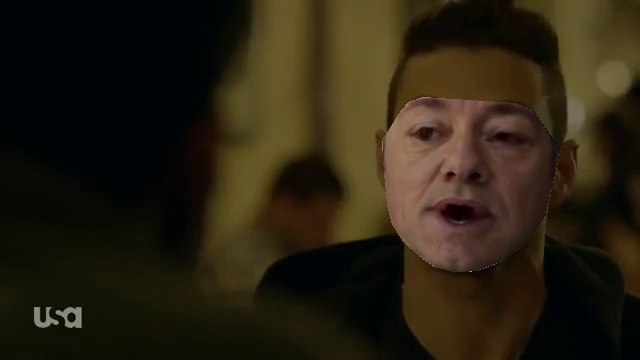

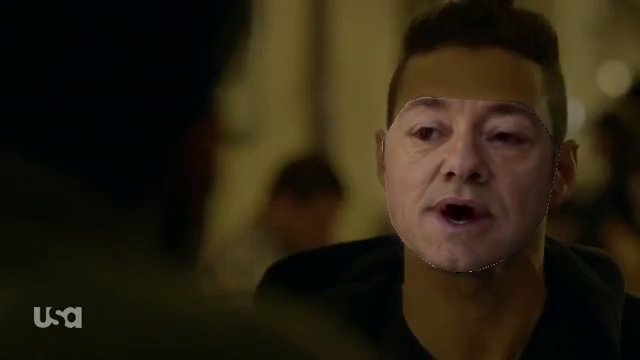

In [214]:
i = 0
while i < 1:
    i += 1
    is_source, source_frame = cap_source.read()
    is_target, target_frame = cap_target.read()
    if is_source and is_target and count_frame < num_frame:
        count_frame += 1
        target_pos_frame = cap_target.get(cv2.CAP_PROP_POS_FRAMES)
        if (target_pos_frame - 1) % frame_rate == 0 or needDetection:
            # STEP 1: Do detection
            det_source = detect_faces(source_frame)
            det_target = detect_faces(target_frame)

            # STEP 2: Extract feature points
            feature_source = extract_feature(source_frame, det_source)[0]
            feature_target = extract_feature(target_frame, det_target)[0]

            # STEP 3: Face Warping
            dissolved_pic = ImageMorphingTriangulation(source_frame, target_frame, feature_source, feature_target)
            convexhull, result = face_swap(source_frame, target_frame, feature_source, feature_target, dissolved_pic)

            # STEP 4: Seamless Blending
            cv2_imshow(result)
            output = LaplacianBlending(result, source_frame, convexhull)
            cv2_imshow(output)

            prev_target_frame = target_frame
            needDetection = True

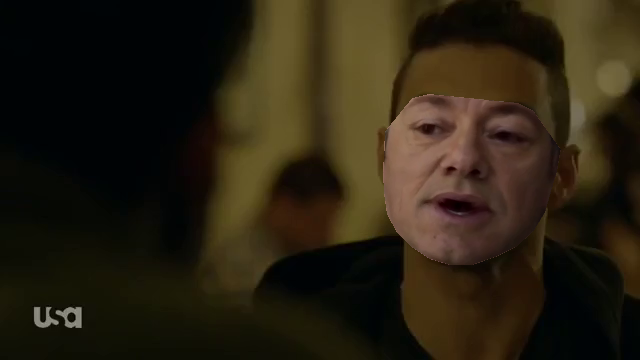

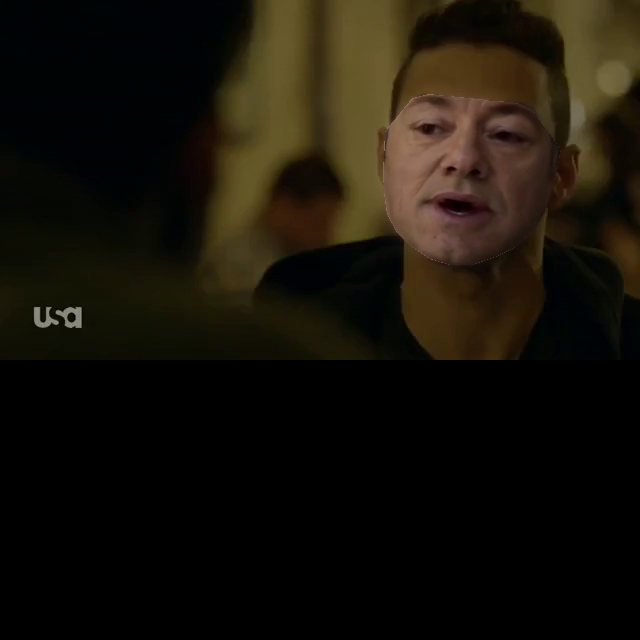

In [202]:
            # STEP 4: Seamless Blending
            cv2_imshow(result)
            output = LaplacianBlending(result, source_frame, convexhull)
            cv2_imshow(output)

            prev_target_frame = target_frame
            needDetection = True